# Autoencoder

In this notebook, we explore the construction and training of a standard Autoencoder using PyTorch, focusing on the MNIST dataset. We will delve into the process of encoding and decoding digit images, highlighting how Autoencoders can effectively learn compressed representations and reconstruct input data. This practical guide aims to provide a clear understanding of Autoencoders.
> Generated by ChatGPT

***

## Loading Libraries

Library | Version | Channel
--- | --- | ---
NumPy | 1.26.4 | default
PyTorch | 2.2.2 | pytorch
Torchvision | 0.17.2 | pytorch
Tensorboard | / | conda-forge
tqdm | / | conda-forge

In [18]:
# Built-in libraries
from dataclasses import dataclass
from datetime import datetime

# Third-party libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm import tqdm

## Hyperparameters

In [19]:
# Batch size
batch_size = 128  # Power of 2 is optimized in many libraries

# Model architecture
size_input = 784
size_hidden = 512
size_latent = 2

# Optimizer
learning_rate = 1e-3
weight_decay = 1e-2

# Training
num_epochs = 50

### Device Specification

The CUDA architecture from NVIDIA enables high-performance parallel computing on GPUs, optimizing tasks through concurrent execution and accelerating applications like deep learning and scientific simulations.
> Generated by ChatGPT

In [20]:
## Established the type of device used for model processing
device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if device == "cuda" else False

## Loading Data

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is a widely-used benchmark in machine learning, consisting of 70,000 images of handwritten digits from 0 to 9. Each image is a 28x28 grayscale pixel grid. Due to its simplicity and well-structured format, MNIST serves as an excellent starting point for developing and testing machine learning models, particularly in the field of image recognition and classification
> Generated by ChatGPT

### Data Transformation

For the model to be able to process the MNIST data, the data has to be transformed into a format that is understandable for our model. The following steps are applied to the data:

1. `v2.ToImage()` - Converts the tensor to an image format
2. `v2.toDtype()` - Converts the img to a floating point tensor
3. `v2.Lambda()` - Zero centers (normalization) the data and flattens it afterward for 1-dimensional input

In [21]:
img_transform = v2.Compose(
    [
        v2.ToImage(),  # Converts tensor to img
        v2.ToDtype(torch.float32, scale=True),  # Converts img to float tensor
        v2.Lambda(lambda x: x.view(-1) - 0.5),  # Zero centers and flattens
    ]
)

### Data Split

In deep learning, data splitting involves dividing the dataset into distinct subsets: typically training, validation, and test sets. This approach ensures that the model is trained on one subset, validated on another to tune hyperparameters, and finally evaluated on a separate set to assess its performance and generalization capability.
> Generated by ChatGPT

In [22]:
# Download and load the training data
train_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=img_transform,
)

## No seperate validation step

# Download and load the test data
test_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=False,
    transform=img_transform,
)

## Create data loaders
## Used to iterate over dataset

# Training data loader
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,  # Shuffle to reduce batch effect
)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [23]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/ubuntu/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           )

In [24]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/ubuntu/.pytorch/MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           )

## The Model

The **autoencoder** is comprised of two primary components: the **encoder** and the **decoder**. The encoder is responsible for reducing the dimensionality of the input tensor. The decoder, in turn, attempts to reconstruct the original input data from the reduced representation generated by the encoder.

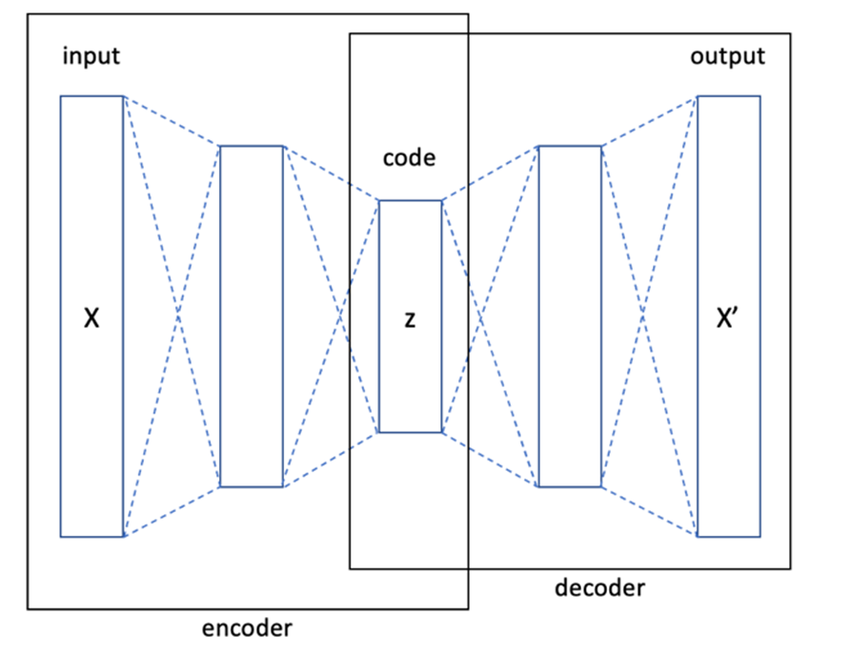  
[Source](https://www.mdpi.com/2076-3417/11/3/1100)

### Output Dataclass

In [25]:
@dataclass
class AEOutput:
    """
    Dataclass for Autoencoder (AE) output.

    Attributes:
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the AE.
        loss (torch.Tensor): The overall loss of the AE.
    """

    z_sample: torch.Tensor
    x_recon: torch.Tensor
    loss: torch.Tensor

### Autoencoder Architecture

In [26]:
class Autoencoder(nn.Module):
    """
    Autoencoder (AE) class.

    Args:
        size_input (int): Dimensionality of the input data.
        size_hidden (int): Dimensionality of the hidden layer.
        size_latent (int): Dimensionality of the latent space
    """

    def __init__(self, size_input: int, size_hidden: int, size_latent: int):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(size_input, size_hidden),
            nn.SiLU(),  # Swish activation function
            nn.Linear(size_hidden, size_hidden // 2),
            nn.SiLU(),
            nn.Linear(size_hidden // 2, size_hidden // 4),
            nn.SiLU(),
            nn.Linear(size_hidden // 4, size_hidden // 8),
            nn.SiLU(),
            nn.Linear(size_hidden // 8, size_latent),
        )
        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential(
            nn.Linear(size_latent, size_hidden // 8),
            nn.SiLU(),
            nn.Linear(size_hidden // 8, size_hidden // 4),
            nn.SiLU(),
            nn.Linear(size_hidden // 4, size_hidden // 2),
            nn.SiLU(),
            nn.Linear(size_hidden // 2, size_hidden),
            nn.SiLU(),
            nn.Linear(size_hidden, size_input),
            nn.Sigmoid(),
        )

        # Set model to device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def encode(self, x):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Input data compressed to latent space.
        """
        return self.encoder(x)

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the AE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            AEOutput: AE output dataclass.
        """
        z = self.encode(x)
        recon_x = self.decode(z)

        if not compute_loss:
            return AEOutput(z_sample=z, x_recon=recon_x, loss=None)

        # compute loss terms
        loss_recon = (
            F.binary_cross_entropy(recon_x, x + 0.5, reduction="none").sum(-1).mean()
        )

        return AEOutput(z_sample=z, x_recon=recon_x, loss=loss_recon)

In [27]:
model = Autoencoder(size_input, size_hidden, size_latent)
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

## Model Training

Training models with PyTorch involves the process of optimizing neural networks to learn patterns and make predictions from data. PyTorch, known for its dynamic computational graph and flexible architecture, facilitates efficient model training through features like automatic differentiation and GPU acceleration, enabling researchers and developers to implement and iterate on complex machine learning algorithms effectively.
> Generated with ChatGPT

Typical training loop:

- Iterating over mini-batches of data
- Forward Pass: Computing model predictions on input data
- Calculating Loss: Using the loss function to measure the discrepancy between predictions and ground truth
- Backward Pass: Computing gradients of the loss with respect to model parameters
- Optimizer Step: Updating model parameters using the optimizer

In [28]:
def train(model, dataloader, optimizer, prev_updates, device, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer (torch.optim.Optim): The optimizer.
        prev_updates (int): Number of previous updates.
        device (str): Device.
        writer: The TensorBoard writer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1.0 / 2)

            print(
                f"Step {n_upd:,} (N samples: {n_upd * dataloader.batch_size:,}), Loss: {loss.item():.4f} Grad: {total_norm:.4f}"
            )

            if writer is not None:
                global_step = n_upd
                writer.add_scalar("Loss/Train", loss.item(), global_step)
                writer.add_scalar("GradNorm/Train", total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [29]:
def test(model, dataloader, cur_step, latent_dim, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()

    test_loss /= len(dataloader)
    print(f"====> Test set loss: {test_loss:.4f}")

    if writer is not None:
        writer.add_scalar("Loss/Test", test_loss, global_step=cur_step)

        # Log reconstructions
        writer.add_images(
            "Test/Reconstructions",
            output.x_recon.view(-1, 1, 28, 28),
            global_step=cur_step,
        )
        writer.add_images(
            "Test/Originals", data.view(-1, 1, 28, 28), global_step=cur_step
        )

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images(
            "Test/Samples", samples.view(-1, 1, 28, 28), global_step=cur_step
        )

In [30]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
writer = SummaryWriter(f'runs/mnist/ae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(
        model, train_loader, optimizer, prev_updates, device, writer=writer
    )
    test(model, test_loader, prev_updates, size_latent, writer=writer)

Epoch 1/50


  1%|          | 3/469 [00:00<00:19, 24.01it/s]

Step 0 (N samples: 0), Loss: 543.7909 Grad: 13.1288


 23%|██▎       | 107/469 [00:03<00:09, 36.35it/s]

Step 100 (N samples: 12,800), Loss: 207.9286 Grad: 19.2956


 44%|████▍     | 207/469 [00:05<00:07, 34.78it/s]

Step 200 (N samples: 25,600), Loss: 210.0080 Grad: 26.4073


 65%|██████▌   | 307/469 [00:08<00:04, 36.45it/s]

Step 300 (N samples: 38,400), Loss: 212.5627 Grad: 19.6221


 86%|████████▌ | 403/469 [00:11<00:02, 28.77it/s]

Step 400 (N samples: 51,200), Loss: 220.6607 Grad: 42.0438


Testing: 100%|██████████| 79/79 [00:01<00:00, 52.07it/s]


====> Test set loss: 207.0986
Epoch 2/50


  8%|▊         | 36/469 [00:00<00:11, 36.50it/s]

Step 500 (N samples: 64,000), Loss: 209.2138 Grad: 36.4607


 29%|██▉       | 136/469 [00:03<00:09, 36.13it/s]

Step 600 (N samples: 76,800), Loss: 201.5464 Grad: 36.5861


 50%|█████     | 235/469 [00:06<00:10, 22.82it/s]

Step 700 (N samples: 89,600), Loss: 205.6227 Grad: 38.3163


 71%|███████   | 334/469 [00:14<00:12, 11.02it/s]

Step 800 (N samples: 102,400), Loss: 202.5114 Grad: 36.5496


 93%|█████████▎| 434/469 [00:23<00:02, 16.52it/s]

Step 900 (N samples: 115,200), Loss: 214.0259 Grad: 41.4586


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.97it/s]


====> Test set loss: 206.8015
Epoch 3/50


 14%|█▍        | 67/469 [00:02<00:14, 28.40it/s]

Step 1,000 (N samples: 128,000), Loss: 204.1075 Grad: 45.3953


 36%|███▌      | 169/469 [00:05<00:09, 32.58it/s]

Step 1,100 (N samples: 140,800), Loss: 206.5807 Grad: 33.7387


 57%|█████▋    | 269/469 [00:08<00:06, 31.61it/s]

Step 1,200 (N samples: 153,600), Loss: 203.5638 Grad: 41.6750


 78%|███████▊  | 365/469 [00:12<00:04, 25.90it/s]

Step 1,300 (N samples: 166,400), Loss: 208.1551 Grad: 34.3606


 99%|█████████▉| 466/469 [00:17<00:00, 17.74it/s]

Step 1,400 (N samples: 179,200), Loss: 202.9372 Grad: 32.5742


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s]


====> Test set loss: 206.6307
Epoch 4/50


 20%|██        | 96/469 [00:05<00:22, 16.73it/s]

Step 1,500 (N samples: 192,000), Loss: 203.8799 Grad: 37.6986


 42%|████▏     | 196/469 [00:13<00:24, 11.28it/s]

Step 1,600 (N samples: 204,800), Loss: 207.9680 Grad: 32.9426


 63%|██████▎   | 296/469 [00:22<00:15, 11.03it/s]

Step 1,700 (N samples: 217,600), Loss: 199.6794 Grad: 42.0603


 84%|████████▍ | 396/469 [00:31<00:06, 11.32it/s]

Step 1,800 (N samples: 230,400), Loss: 210.4288 Grad: 37.8439


Testing: 100%|██████████| 79/79 [00:05<00:00, 14.49it/s]


====> Test set loss: 206.5480
Epoch 5/50


  6%|▌         | 26/469 [00:02<00:44, 10.04it/s]

Step 1,900 (N samples: 243,200), Loss: 215.0003 Grad: 39.7171


 27%|██▋       | 126/469 [00:13<00:39,  8.68it/s]

Step 2,000 (N samples: 256,000), Loss: 210.6357 Grad: 41.5743


 48%|████▊     | 226/469 [00:25<00:29,  8.13it/s]

Step 2,100 (N samples: 268,800), Loss: 211.8297 Grad: 41.8051


 70%|██████▉   | 326/469 [00:37<00:19,  7.45it/s]

Step 2,200 (N samples: 281,600), Loss: 210.7449 Grad: 40.3037


 91%|█████████ | 426/469 [00:51<00:06,  7.11it/s]

Step 2,300 (N samples: 294,400), Loss: 211.2053 Grad: 44.1711


Testing: 100%|██████████| 79/79 [00:06<00:00, 12.04it/s]


====> Test set loss: 206.4231
Epoch 6/50


 12%|█▏        | 57/469 [00:08<01:03,  6.52it/s]

Step 2,400 (N samples: 307,200), Loss: 208.5611 Grad: 39.6173


 33%|███▎      | 157/469 [00:24<00:52,  5.96it/s]

Step 2,500 (N samples: 320,000), Loss: 213.9876 Grad: 36.5355


 55%|█████▍    | 257/469 [00:42<00:37,  5.68it/s]

Step 2,600 (N samples: 332,800), Loss: 203.5506 Grad: 35.6319


 76%|███████▌  | 357/469 [00:59<00:18,  6.02it/s]

Step 2,700 (N samples: 345,600), Loss: 206.8664 Grad: 45.4042


 97%|█████████▋| 457/469 [01:16<00:02,  5.84it/s]

Step 2,800 (N samples: 358,400), Loss: 212.0324 Grad: 43.0162


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


====> Test set loss: 206.7212
Epoch 7/50


 19%|█▉        | 88/469 [00:15<01:05,  5.85it/s]

Step 2,900 (N samples: 371,200), Loss: 210.1885 Grad: 45.4984


 40%|███▉      | 187/469 [00:38<01:05,  4.32it/s]

Step 3,000 (N samples: 384,000), Loss: 207.4569 Grad: 43.5340


 61%|██████    | 287/469 [00:59<00:37,  4.86it/s]

Step 3,100 (N samples: 396,800), Loss: 206.7738 Grad: 41.5348


 83%|████████▎ | 387/469 [01:20<00:16,  4.90it/s]

Step 3,200 (N samples: 409,600), Loss: 204.9982 Grad: 48.7778


Testing: 100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


====> Test set loss: 206.8207
Epoch 8/50


  4%|▍         | 18/469 [00:03<01:36,  4.66it/s]

Step 3,300 (N samples: 422,400), Loss: 201.9247 Grad: 43.7102


 25%|██▌       | 118/469 [00:25<01:17,  4.53it/s]

Step 3,400 (N samples: 435,200), Loss: 204.9021 Grad: 36.1558


 46%|████▋     | 218/469 [00:47<00:52,  4.75it/s]

Step 3,500 (N samples: 448,000), Loss: 203.6355 Grad: 42.3244


 68%|██████▊   | 319/469 [01:07<00:27,  5.37it/s]

Step 3,600 (N samples: 460,800), Loss: 202.9519 Grad: 45.4488


 89%|████████▉ | 418/469 [01:25<00:10,  4.97it/s]

Step 3,700 (N samples: 473,600), Loss: 202.9602 Grad: 42.3706


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.07it/s]


====> Test set loss: 206.2590
Epoch 9/50


 10%|█         | 49/469 [00:09<01:22,  5.08it/s]

Step 3,800 (N samples: 486,400), Loss: 209.7275 Grad: 36.8208


 32%|███▏      | 149/469 [00:28<00:59,  5.38it/s]

Step 3,900 (N samples: 499,200), Loss: 205.9753 Grad: 33.8574


 53%|█████▎    | 250/469 [00:46<00:39,  5.57it/s]

Step 4,000 (N samples: 512,000), Loss: 217.1641 Grad: 49.8747


 75%|███████▍  | 350/469 [01:03<00:20,  5.86it/s]

Step 4,100 (N samples: 524,800), Loss: 200.5375 Grad: 45.3766


 96%|█████████▌| 450/469 [01:20<00:03,  6.11it/s]

Step 4,200 (N samples: 537,600), Loss: 198.2128 Grad: 47.7813


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.02it/s]


====> Test set loss: 206.5725
Epoch 10/50


 17%|█▋        | 81/469 [00:15<01:08,  5.63it/s]

Step 4,300 (N samples: 550,400), Loss: 209.0074 Grad: 36.7539


 39%|███▊      | 181/469 [00:31<00:46,  6.25it/s]

Step 4,400 (N samples: 563,200), Loss: 206.6402 Grad: 33.7936


 60%|█████▉    | 281/469 [00:47<00:31,  6.01it/s]

Step 4,500 (N samples: 576,000), Loss: 206.6306 Grad: 41.4405


 81%|████████  | 381/469 [01:03<00:13,  6.45it/s]

Step 4,600 (N samples: 588,800), Loss: 199.8935 Grad: 39.9692


Testing: 100%|██████████| 79/79 [00:07<00:00, 10.24it/s]


====> Test set loss: 206.1112
Epoch 11/50


  3%|▎         | 12/469 [00:02<01:21,  5.58it/s]

Step 4,700 (N samples: 601,600), Loss: 209.6939 Grad: 37.0054


 24%|██▍       | 112/469 [08:21<00:42,  8.48it/s]   

Step 4,800 (N samples: 614,400), Loss: 212.6511 Grad: 52.8348


 45%|████▌     | 212/469 [08:32<00:26,  9.64it/s]

Step 4,900 (N samples: 627,200), Loss: 209.8231 Grad: 38.5666


 67%|██████▋   | 312/469 [08:42<00:14, 10.60it/s]

Step 5,000 (N samples: 640,000), Loss: 207.5677 Grad: 31.4599


 88%|████████▊ | 412/469 [08:52<00:05, 11.36it/s]

Step 5,100 (N samples: 652,800), Loss: 209.3107 Grad: 35.7738


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.11it/s]


====> Test set loss: 206.3608
Epoch 12/50


  9%|▉         | 44/469 [00:03<00:36, 11.57it/s]

Step 5,200 (N samples: 665,600), Loss: 214.1378 Grad: 40.0903


 31%|███       | 144/469 [00:12<00:27, 11.94it/s]

Step 5,300 (N samples: 678,400), Loss: 203.3893 Grad: 48.5509


 52%|█████▏    | 244/469 [00:20<00:17, 12.55it/s]

Step 5,400 (N samples: 691,200), Loss: 209.7617 Grad: 31.9369


 73%|███████▎  | 344/469 [00:28<00:09, 12.51it/s]

Step 5,500 (N samples: 704,000), Loss: 196.5977 Grad: 46.3691


 95%|█████████▍| 444/469 [00:37<00:02, 11.79it/s]

Step 5,600 (N samples: 716,800), Loss: 213.6419 Grad: 54.0225


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.64it/s]


====> Test set loss: 206.5392
Epoch 13/50


 16%|█▌        | 74/469 [00:05<00:31, 12.45it/s]

Step 5,700 (N samples: 729,600), Loss: 204.6267 Grad: 37.7371


 37%|███▋      | 174/469 [00:14<00:25, 11.77it/s]

Step 5,800 (N samples: 742,400), Loss: 209.9623 Grad: 33.5543


 58%|█████▊    | 274/469 [00:22<00:15, 12.22it/s]

Step 5,900 (N samples: 755,200), Loss: 207.9587 Grad: 42.1663


 80%|███████▉  | 374/469 [00:30<00:07, 11.96it/s]

Step 6,000 (N samples: 768,000), Loss: 208.4845 Grad: 35.5684


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.00it/s]


====> Test set loss: 206.3182
Epoch 14/50


  1%|▏         | 6/469 [00:00<00:38, 12.09it/s]

Step 6,100 (N samples: 780,800), Loss: 207.5515 Grad: 37.6187


 23%|██▎       | 106/469 [00:09<00:30, 11.78it/s]

Step 6,200 (N samples: 793,600), Loss: 204.2205 Grad: 33.2804


 44%|████▍     | 206/469 [00:17<00:24, 10.92it/s]

Step 6,300 (N samples: 806,400), Loss: 207.4199 Grad: 35.6245


 65%|██████▍   | 304/469 [00:27<00:14, 11.08it/s]

Step 6,400 (N samples: 819,200), Loss: 204.0295 Grad: 32.8380


 86%|████████▌ | 404/469 [00:37<00:06,  9.93it/s]

Step 6,500 (N samples: 832,000), Loss: 206.6110 Grad: 37.7595


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.87it/s]


====> Test set loss: 206.4271
Epoch 15/50


  8%|▊         | 36/469 [00:03<00:39, 10.99it/s]

Step 6,600 (N samples: 844,800), Loss: 201.4187 Grad: 42.3486


 29%|██▉       | 137/469 [00:12<00:31, 10.69it/s]

Step 6,700 (N samples: 857,600), Loss: 208.3446 Grad: 38.6601


 51%|█████     | 237/469 [00:22<00:22, 10.49it/s]

Step 6,800 (N samples: 870,400), Loss: 204.6529 Grad: 37.6860


 72%|███████▏  | 337/469 [00:31<00:12, 10.70it/s]

Step 6,900 (N samples: 883,200), Loss: 205.4778 Grad: 45.9491


 93%|█████████▎| 437/469 [00:40<00:02, 10.70it/s]

Step 7,000 (N samples: 896,000), Loss: 212.4060 Grad: 49.6075


Testing: 100%|██████████| 79/79 [00:03<00:00, 23.41it/s]


====> Test set loss: 206.4892
Epoch 16/50


 14%|█▍        | 66/469 [00:06<00:38, 10.56it/s]

Step 7,100 (N samples: 908,800), Loss: 208.3804 Grad: 36.4236


 36%|███▌      | 168/469 [00:15<00:28, 10.71it/s]

Step 7,200 (N samples: 921,600), Loss: 205.7247 Grad: 33.7613


 57%|█████▋    | 266/469 [00:24<00:19, 10.30it/s]

Step 7,300 (N samples: 934,400), Loss: 211.9456 Grad: 41.4558


 78%|███████▊  | 367/469 [00:34<00:09, 10.67it/s]

Step 7,400 (N samples: 947,200), Loss: 203.9167 Grad: 40.6316


100%|█████████▉| 467/469 [00:43<00:00, 10.89it/s]

Step 7,500 (N samples: 960,000), Loss: 200.6933 Grad: 42.7994


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.33it/s]


====> Test set loss: 206.4425
Epoch 17/50


 21%|██        | 99/469 [00:09<00:34, 10.79it/s]

Step 7,600 (N samples: 972,800), Loss: 207.9931 Grad: 42.6872


 42%|████▏     | 199/469 [00:18<00:24, 11.08it/s]

Step 7,700 (N samples: 985,600), Loss: 210.1592 Grad: 29.5548


 64%|██████▍   | 299/469 [00:27<00:15, 10.93it/s]

Step 7,800 (N samples: 998,400), Loss: 205.7952 Grad: 40.6185


 85%|████████▌ | 399/469 [00:37<00:06, 10.96it/s]

Step 7,900 (N samples: 1,011,200), Loss: 212.3316 Grad: 47.6686


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.32it/s]


====> Test set loss: 206.2465
Epoch 18/50


  6%|▋         | 30/469 [00:02<00:39, 11.01it/s]

Step 8,000 (N samples: 1,024,000), Loss: 208.2823 Grad: 38.8430


 28%|██▊       | 130/469 [00:11<00:30, 11.09it/s]

Step 8,100 (N samples: 1,036,800), Loss: 204.3231 Grad: 39.1051


 49%|████▉     | 229/469 [00:21<00:21, 11.18it/s]

Step 8,200 (N samples: 1,049,600), Loss: 211.9527 Grad: 37.1389


 70%|███████   | 329/469 [00:30<00:12, 11.16it/s]

Step 8,300 (N samples: 1,062,400), Loss: 205.0042 Grad: 46.3415


 91%|█████████▏| 429/469 [00:39<00:03, 11.31it/s]

Step 8,400 (N samples: 1,075,200), Loss: 204.3531 Grad: 34.2638


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.38it/s]


====> Test set loss: 206.4588
Epoch 19/50


 13%|█▎        | 60/469 [00:05<00:37, 10.85it/s]

Step 8,500 (N samples: 1,088,000), Loss: 205.4150 Grad: 46.0583


 34%|███▍      | 160/469 [00:14<00:28, 10.95it/s]

Step 8,600 (N samples: 1,100,800), Loss: 206.4790 Grad: 41.5330


 55%|█████▌    | 260/469 [00:23<00:18, 11.05it/s]

Step 8,700 (N samples: 1,113,600), Loss: 205.9046 Grad: 42.1621


 77%|███████▋  | 360/469 [00:32<00:09, 11.16it/s]

Step 8,800 (N samples: 1,126,400), Loss: 204.0680 Grad: 34.1635


 98%|█████████▊| 460/469 [00:41<00:00, 11.45it/s]

Step 8,900 (N samples: 1,139,200), Loss: 209.1026 Grad: 36.2592


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.28it/s]


====> Test set loss: 206.3988
Epoch 20/50


 19%|█▉        | 91/469 [00:07<00:32, 11.62it/s]

Step 9,000 (N samples: 1,152,000), Loss: 202.8669 Grad: 38.1214


 41%|████      | 191/469 [00:16<00:24, 11.39it/s]

Step 9,100 (N samples: 1,164,800), Loss: 206.5058 Grad: 51.8210


 62%|██████▏   | 291/469 [00:25<00:15, 11.24it/s]

Step 9,200 (N samples: 1,177,600), Loss: 207.1742 Grad: 44.8680


 83%|████████▎ | 391/469 [00:34<00:06, 11.48it/s]

Step 9,300 (N samples: 1,190,400), Loss: 205.1707 Grad: 38.1737


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.27it/s]


====> Test set loss: 206.2399
Epoch 21/50


  5%|▍         | 22/469 [00:01<00:39, 11.34it/s]

Step 9,400 (N samples: 1,203,200), Loss: 211.3065 Grad: 46.1775


 26%|██▌       | 122/469 [00:10<00:30, 11.49it/s]

Step 9,500 (N samples: 1,216,000), Loss: 201.6652 Grad: 40.2131


 47%|████▋     | 222/469 [00:19<00:20, 11.97it/s]

Step 9,600 (N samples: 1,228,800), Loss: 208.3710 Grad: 39.0423


 69%|██████▊   | 322/469 [00:27<00:12, 11.95it/s]

Step 9,700 (N samples: 1,241,600), Loss: 203.0957 Grad: 49.6923


 90%|████████▉ | 422/469 [00:35<00:03, 12.02it/s]

Step 9,800 (N samples: 1,254,400), Loss: 201.9332 Grad: 38.7151


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.44it/s]


====> Test set loss: 206.2244
Epoch 22/50


 12%|█▏        | 54/469 [00:04<00:34, 12.08it/s]

Step 9,900 (N samples: 1,267,200), Loss: 205.1344 Grad: 42.6718


 32%|███▏      | 152/469 [00:12<00:26, 11.78it/s]

Step 10,000 (N samples: 1,280,000), Loss: 209.9480 Grad: 36.5021


 54%|█████▍    | 254/469 [00:23<00:17, 12.28it/s]

Step 10,100 (N samples: 1,292,800), Loss: 207.8758 Grad: 44.7011


 75%|███████▌  | 354/469 [00:31<00:09, 12.00it/s]

Step 10,200 (N samples: 1,305,600), Loss: 209.7952 Grad: 35.6551


 97%|█████████▋| 454/469 [00:39<00:01, 12.39it/s]

Step 10,300 (N samples: 1,318,400), Loss: 206.6608 Grad: 36.6019


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.77it/s]


====> Test set loss: 206.1887
Epoch 23/50


 18%|█▊        | 84/469 [00:06<00:30, 12.76it/s]

Step 10,400 (N samples: 1,331,200), Loss: 204.9678 Grad: 38.1303


 39%|███▉      | 184/469 [00:14<00:21, 13.40it/s]

Step 10,500 (N samples: 1,344,000), Loss: 202.9783 Grad: 47.6773


 61%|██████    | 284/469 [00:21<00:13, 13.39it/s]

Step 10,600 (N samples: 1,356,800), Loss: 203.7452 Grad: 37.9935


 82%|████████▏ | 384/469 [00:29<00:07, 11.66it/s]

Step 10,700 (N samples: 1,369,600), Loss: 209.0507 Grad: 42.9639


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.04it/s]


====> Test set loss: 206.1530
Epoch 24/50


  3%|▎         | 16/469 [00:01<00:36, 12.47it/s]

Step 10,800 (N samples: 1,382,400), Loss: 209.6698 Grad: 41.6617


 25%|██▍       | 116/469 [00:08<00:25, 13.70it/s]

Step 10,900 (N samples: 1,395,200), Loss: 207.3997 Grad: 42.0235


 46%|████▌     | 216/469 [00:16<00:18, 13.69it/s]

Step 11,000 (N samples: 1,408,000), Loss: 211.8497 Grad: 35.4328


 67%|██████▋   | 315/469 [00:24<00:17,  8.85it/s]

Step 11,100 (N samples: 1,420,800), Loss: 200.4664 Grad: 44.7155


 88%|████████▊ | 415/469 [00:31<00:04, 12.80it/s]

Step 11,200 (N samples: 1,433,600), Loss: 205.0573 Grad: 38.1687


Testing: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s]


====> Test set loss: 206.4527
Epoch 25/50


 10%|█         | 47/469 [00:06<00:39, 10.60it/s]

Step 11,300 (N samples: 1,446,400), Loss: 204.7014 Grad: 46.0060


 31%|███▏      | 147/469 [33:52<01:38,  3.26it/s]    

Step 11,400 (N samples: 1,459,200), Loss: 206.5294 Grad: 37.0314


 53%|█████▎    | 247/469 [33:59<00:12, 18.39it/s]

Step 11,500 (N samples: 1,472,000), Loss: 204.6523 Grad: 43.5858


 74%|███████▍  | 347/469 [34:04<00:06, 19.73it/s]

Step 11,600 (N samples: 1,484,800), Loss: 206.9405 Grad: 43.9025


 95%|█████████▌| 447/469 [34:09<00:01, 19.42it/s]

Step 11,700 (N samples: 1,497,600), Loss: 201.6373 Grad: 36.9370


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.17it/s]


====> Test set loss: 206.2179
Epoch 26/50


 17%|█▋        | 78/469 [00:03<00:19, 19.61it/s]

Step 11,800 (N samples: 1,510,400), Loss: 214.3531 Grad: 45.3696


 38%|███▊      | 178/469 [00:08<00:14, 19.72it/s]

Step 11,900 (N samples: 1,523,200), Loss: 207.6185 Grad: 41.5519


 59%|█████▉    | 279/469 [00:13<00:08, 21.16it/s]

Step 12,000 (N samples: 1,536,000), Loss: 219.8396 Grad: 63.5875


 81%|████████  | 378/469 [00:18<00:04, 21.44it/s]

Step 12,100 (N samples: 1,548,800), Loss: 201.6322 Grad: 45.7537


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.75it/s]


====> Test set loss: 206.4684
Epoch 27/50


  2%|▏         | 11/469 [00:00<00:21, 21.69it/s]

Step 12,200 (N samples: 1,561,600), Loss: 208.2766 Grad: 34.0350


 23%|██▎       | 110/469 [00:05<00:16, 22.17it/s]

Step 12,300 (N samples: 1,574,400), Loss: 206.0360 Grad: 43.4248


 45%|████▍     | 209/469 [00:09<00:11, 22.23it/s]

Step 12,400 (N samples: 1,587,200), Loss: 213.6326 Grad: 48.7145


 66%|██████▋   | 311/469 [00:14<00:07, 21.09it/s]

Step 12,500 (N samples: 1,600,000), Loss: 201.9449 Grad: 35.3114


 87%|████████▋ | 410/469 [00:18<00:02, 24.22it/s]

Step 12,600 (N samples: 1,612,800), Loss: 201.3656 Grad: 44.5694


Testing: 100%|██████████| 79/79 [00:01<00:00, 47.39it/s]


====> Test set loss: 206.2727
Epoch 28/50


  9%|▉         | 42/469 [00:01<00:16, 25.46it/s]

Step 12,700 (N samples: 1,625,600), Loss: 209.9594 Grad: 40.9831


 30%|███       | 141/469 [00:05<00:12, 25.24it/s]

Step 12,800 (N samples: 1,638,400), Loss: 205.3785 Grad: 37.2472


 52%|█████▏    | 243/469 [00:09<00:08, 25.37it/s]

Step 12,900 (N samples: 1,651,200), Loss: 204.6149 Grad: 40.4765


 73%|███████▎  | 343/469 [00:13<00:04, 27.79it/s]

Step 13,000 (N samples: 1,664,000), Loss: 209.4642 Grad: 42.0887


 94%|█████████▍| 442/469 [00:16<00:00, 28.46it/s]

Step 13,100 (N samples: 1,676,800), Loss: 219.8353 Grad: 57.5954


Testing: 100%|██████████| 79/79 [00:01<00:00, 48.50it/s]


====> Test set loss: 206.1880
Epoch 29/50


 15%|█▌        | 72/469 [00:02<00:14, 28.13it/s]

Step 13,200 (N samples: 1,689,600), Loss: 213.1749 Grad: 41.6761


 37%|███▋      | 174/469 [00:06<00:10, 27.60it/s]

Step 13,300 (N samples: 1,702,400), Loss: 205.6297 Grad: 40.7350


 58%|█████▊    | 273/469 [00:09<00:07, 25.16it/s]

Step 13,400 (N samples: 1,715,200), Loss: 198.2743 Grad: 42.2623


 80%|███████▉  | 374/469 [00:13<00:03, 29.15it/s]

Step 13,500 (N samples: 1,728,000), Loss: 205.3146 Grad: 30.9016


100%|██████████| 469/469 [00:16<00:00, 27.98it/s]


Step 13,600 (N samples: 1,740,800), Loss: 209.4526 Grad: 41.3988


Testing: 100%|██████████| 79/79 [00:01<00:00, 47.22it/s]


====> Test set loss: 206.2769
Epoch 30/50


 22%|██▏       | 105/469 [00:03<00:12, 28.66it/s]

Step 13,700 (N samples: 1,753,600), Loss: 209.7735 Grad: 35.9783


 43%|████▎     | 204/469 [00:07<00:09, 28.34it/s]

Step 13,800 (N samples: 1,766,400), Loss: 206.6035 Grad: 38.0508


 65%|██████▍   | 303/469 [00:10<00:06, 26.37it/s]

Step 13,900 (N samples: 1,779,200), Loss: 205.8943 Grad: 39.9006


 86%|████████▌ | 403/469 [00:14<00:02, 27.79it/s]

Step 14,000 (N samples: 1,792,000), Loss: 206.9159 Grad: 42.1717


Testing: 100%|██████████| 79/79 [00:01<00:00, 48.51it/s]


====> Test set loss: 206.3506
Epoch 31/50


  7%|▋         | 33/469 [00:01<00:15, 28.11it/s]

Step 14,100 (N samples: 1,804,800), Loss: 209.4741 Grad: 38.9629


 29%|██▉       | 136/469 [00:04<00:11, 28.39it/s]

Step 14,200 (N samples: 1,817,600), Loss: 207.0622 Grad: 35.1121


 50%|█████     | 236/469 [00:08<00:08, 28.40it/s]

Step 14,300 (N samples: 1,830,400), Loss: 208.6811 Grad: 33.3654


 71%|███████▏  | 335/469 [00:11<00:04, 29.67it/s]

Step 14,400 (N samples: 1,843,200), Loss: 201.4644 Grad: 41.0558


 93%|█████████▎| 435/469 [00:15<00:01, 28.51it/s]

Step 14,500 (N samples: 1,856,000), Loss: 205.9352 Grad: 33.3024


Testing: 100%|██████████| 79/79 [00:01<00:00, 49.11it/s]


====> Test set loss: 206.1506
Epoch 32/50


 14%|█▍        | 65/469 [00:02<00:14, 28.73it/s]

Step 14,600 (N samples: 1,868,800), Loss: 200.6936 Grad: 41.5874


 36%|███▌      | 167/469 [00:05<00:10, 29.69it/s]

Step 14,700 (N samples: 1,881,600), Loss: 206.4349 Grad: 50.7187


 57%|█████▋    | 267/469 [00:09<00:07, 27.81it/s]

Step 14,800 (N samples: 1,894,400), Loss: 202.4878 Grad: 38.1585


 78%|███████▊  | 366/469 [00:13<00:03, 26.55it/s]

Step 14,900 (N samples: 1,907,200), Loss: 207.7704 Grad: 41.3067


 99%|█████████▉| 465/469 [00:17<00:00, 25.54it/s]

Step 15,000 (N samples: 1,920,000), Loss: 207.4876 Grad: 45.8484


Testing: 100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


====> Test set loss: 206.2563
Epoch 33/50


 20%|██        | 96/469 [00:03<00:14, 25.08it/s]

Step 15,100 (N samples: 1,932,800), Loss: 206.1615 Grad: 37.9372


 42%|████▏     | 195/469 [00:07<00:12, 21.94it/s]

Step 15,200 (N samples: 1,945,600), Loss: 207.2162 Grad: 44.6091


 63%|██████▎   | 294/469 [00:12<00:08, 20.93it/s]

Step 15,300 (N samples: 1,958,400), Loss: 203.8089 Grad: 42.6091


 84%|████████▍ | 395/469 [00:17<00:03, 20.15it/s]

Step 15,400 (N samples: 1,971,200), Loss: 205.4662 Grad: 36.0709


Testing: 100%|██████████| 79/79 [00:01<00:00, 43.00it/s]


====> Test set loss: 206.2961
Epoch 34/50


  6%|▌         | 27/469 [00:01<00:18, 24.55it/s]

Step 15,500 (N samples: 1,984,000), Loss: 200.3825 Grad: 49.0266


 28%|██▊       | 129/469 [00:05<00:13, 25.75it/s]

Step 15,600 (N samples: 1,996,800), Loss: 205.4143 Grad: 36.0461


 49%|████▊     | 228/469 [00:09<00:09, 25.74it/s]

Step 15,700 (N samples: 2,009,600), Loss: 203.8919 Grad: 40.0512


 70%|██████▉   | 327/469 [00:13<00:05, 24.74it/s]

Step 15,800 (N samples: 2,022,400), Loss: 205.3517 Grad: 40.5936


 91%|█████████ | 426/469 [00:17<00:01, 22.76it/s]

Step 15,900 (N samples: 2,035,200), Loss: 205.9160 Grad: 41.2841


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.53it/s]


====> Test set loss: 206.4295
Epoch 35/50


 12%|█▏        | 58/469 [00:03<00:19, 20.89it/s]

Step 16,000 (N samples: 2,048,000), Loss: 212.3139 Grad: 53.9313


 33%|███▎      | 157/469 [00:09<00:16, 19.45it/s]

Step 16,100 (N samples: 2,060,800), Loss: 202.2127 Grad: 45.9986


 55%|█████▍    | 257/469 [00:15<00:13, 15.74it/s]

Step 16,200 (N samples: 2,073,600), Loss: 205.5064 Grad: 46.5001


 76%|███████▌  | 355/469 [00:23<00:13,  8.66it/s]

Step 16,300 (N samples: 2,086,400), Loss: 206.8228 Grad: 42.0648


 98%|█████████▊| 459/469 [00:30<00:00, 22.25it/s]

Step 16,400 (N samples: 2,099,200), Loss: 205.4787 Grad: 42.9791


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.28it/s]


====> Test set loss: 206.3164
Epoch 36/50


 19%|█▉        | 90/469 [00:04<00:16, 22.48it/s]

Step 16,500 (N samples: 2,112,000), Loss: 199.9519 Grad: 53.0941


 40%|████      | 188/469 [00:09<00:15, 17.65it/s]

Step 16,600 (N samples: 2,124,800), Loss: 210.6617 Grad: 48.0022


 61%|██████▏   | 288/469 [00:15<00:11, 16.14it/s]

Step 16,700 (N samples: 2,137,600), Loss: 211.2755 Grad: 54.5516


 83%|████████▎ | 389/469 [00:21<00:04, 18.10it/s]

Step 16,800 (N samples: 2,150,400), Loss: 207.5116 Grad: 39.9316


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s]


====> Test set loss: 206.1290
Epoch 37/50


  4%|▍         | 20/469 [00:01<00:24, 18.10it/s]

Step 16,900 (N samples: 2,163,200), Loss: 207.2615 Grad: 39.6268


 26%|██▌       | 120/469 [00:06<00:18, 18.55it/s]

Step 17,000 (N samples: 2,176,000), Loss: 210.7943 Grad: 36.2043


 47%|████▋     | 219/469 [00:11<00:11, 22.68it/s]

Step 17,100 (N samples: 2,188,800), Loss: 205.0853 Grad: 45.9089


 68%|██████▊   | 321/469 [00:15<00:06, 23.07it/s]

Step 17,200 (N samples: 2,201,600), Loss: 207.0060 Grad: 40.2716


 90%|████████▉ | 420/469 [00:20<00:02, 21.03it/s]

Step 17,300 (N samples: 2,214,400), Loss: 210.1015 Grad: 37.9563


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.02it/s]


====> Test set loss: 206.2102
Epoch 38/50


 11%|█         | 51/469 [00:02<00:19, 21.48it/s]

Step 17,400 (N samples: 2,227,200), Loss: 208.8600 Grad: 45.3167


 32%|███▏      | 152/469 [00:07<00:14, 22.39it/s]

Step 17,500 (N samples: 2,240,000), Loss: 207.4024 Grad: 48.6086


 54%|█████▎    | 251/469 [00:11<00:09, 23.20it/s]

Step 17,600 (N samples: 2,252,800), Loss: 208.5521 Grad: 44.9827


 75%|███████▍  | 350/469 [00:16<00:05, 23.02it/s]

Step 17,700 (N samples: 2,265,600), Loss: 203.4284 Grad: 35.3573


 96%|█████████▋| 452/469 [00:20<00:00, 22.81it/s]

Step 17,800 (N samples: 2,278,400), Loss: 209.5873 Grad: 38.9791


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.89it/s]


====> Test set loss: 206.2344
Epoch 39/50


 17%|█▋        | 81/469 [00:03<00:16, 22.85it/s]

Step 17,900 (N samples: 2,291,200), Loss: 203.0663 Grad: 45.1711


 39%|███▉      | 182/469 [00:08<00:12, 23.46it/s]

Step 18,000 (N samples: 2,304,000), Loss: 212.7359 Grad: 45.5311


 60%|█████▉    | 281/469 [00:12<00:09, 19.06it/s]

Step 18,100 (N samples: 2,316,800), Loss: 204.6075 Grad: 38.8114


 81%|████████  | 381/469 [00:17<00:03, 23.33it/s]

Step 18,200 (N samples: 2,329,600), Loss: 213.0738 Grad: 46.6732


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.54it/s]


====> Test set loss: 206.1881
Epoch 40/50


  3%|▎         | 14/469 [00:00<00:22, 20.53it/s]

Step 18,300 (N samples: 2,342,400), Loss: 207.7208 Grad: 34.7455


 24%|██▍       | 113/469 [00:05<00:15, 22.36it/s]

Step 18,400 (N samples: 2,355,200), Loss: 212.6872 Grad: 41.3074


 45%|████▌     | 212/469 [00:10<00:11, 22.52it/s]

Step 18,500 (N samples: 2,368,000), Loss: 201.1137 Grad: 44.5762


 67%|██████▋   | 314/469 [00:14<00:07, 21.89it/s]

Step 18,600 (N samples: 2,380,800), Loss: 207.5465 Grad: 38.3094


 88%|████████▊ | 412/469 [00:19<00:02, 21.08it/s]

Step 18,700 (N samples: 2,393,600), Loss: 207.2430 Grad: 35.1891


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.55it/s]


====> Test set loss: 206.5840
Epoch 41/50


  9%|▉         | 44/469 [00:02<00:19, 21.62it/s]

Step 18,800 (N samples: 2,406,400), Loss: 199.3514 Grad: 43.0765


 31%|███       | 144/469 [00:07<00:20, 15.80it/s]

Step 18,900 (N samples: 2,419,200), Loss: 209.0294 Grad: 40.9025


 52%|█████▏    | 244/469 [00:12<00:09, 22.65it/s]

Step 19,000 (N samples: 2,432,000), Loss: 202.1184 Grad: 35.6704


 73%|███████▎  | 342/469 [00:17<00:09, 12.93it/s]

Step 19,100 (N samples: 2,444,800), Loss: 205.6580 Grad: 38.0647


 95%|█████████▍| 445/469 [00:22<00:01, 22.78it/s]

Step 19,200 (N samples: 2,457,600), Loss: 204.8167 Grad: 42.8320


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.26it/s]


====> Test set loss: 206.2728
Epoch 42/50


 16%|█▌        | 76/469 [00:03<00:17, 22.84it/s]

Step 19,300 (N samples: 2,470,400), Loss: 203.9456 Grad: 38.3596


 37%|███▋      | 175/469 [00:08<00:13, 22.07it/s]

Step 19,400 (N samples: 2,483,200), Loss: 198.0550 Grad: 47.1962


 58%|█████▊    | 274/469 [00:12<00:08, 22.70it/s]

Step 19,500 (N samples: 2,496,000), Loss: 208.7511 Grad: 41.5571


 80%|███████▉  | 373/469 [00:17<00:04, 20.90it/s]

Step 19,600 (N samples: 2,508,800), Loss: 204.5045 Grad: 50.4136


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.68it/s]


====> Test set loss: 206.2084
Epoch 43/50


  1%|▏         | 6/469 [00:00<00:26, 17.68it/s]

Step 19,700 (N samples: 2,521,600), Loss: 207.2064 Grad: 49.2609


 23%|██▎       | 107/469 [00:05<00:16, 21.44it/s]

Step 19,800 (N samples: 2,534,400), Loss: 201.4776 Grad: 42.2861


 44%|████▍     | 207/469 [00:09<00:11, 22.51it/s]

Step 19,900 (N samples: 2,547,200), Loss: 198.7918 Grad: 42.6529


 65%|██████▌   | 306/469 [00:14<00:07, 21.52it/s]

Step 20,000 (N samples: 2,560,000), Loss: 206.7123 Grad: 37.1489


 86%|████████▋ | 405/469 [00:18<00:02, 21.90it/s]

Step 20,100 (N samples: 2,572,800), Loss: 209.1375 Grad: 36.8200


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.14it/s]


====> Test set loss: 206.2102
Epoch 44/50


  8%|▊         | 37/469 [00:01<00:21, 20.51it/s]

Step 20,200 (N samples: 2,585,600), Loss: 202.7132 Grad: 43.9631


 29%|██▉       | 136/469 [00:06<00:15, 21.40it/s]

Step 20,300 (N samples: 2,598,400), Loss: 206.6048 Grad: 39.8245


 51%|█████     | 237/469 [00:10<00:10, 21.23it/s]

Step 20,400 (N samples: 2,611,200), Loss: 198.1956 Grad: 52.4216


 72%|███████▏  | 336/469 [00:15<00:06, 21.05it/s]

Step 20,500 (N samples: 2,624,000), Loss: 201.7903 Grad: 46.2342


 93%|█████████▎| 437/469 [00:19<00:01, 22.27it/s]

Step 20,600 (N samples: 2,636,800), Loss: 205.7198 Grad: 36.9563


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.74it/s]


====> Test set loss: 206.0773
Epoch 45/50


 15%|█▍        | 69/469 [00:02<00:17, 23.17it/s]

Step 20,700 (N samples: 2,649,600), Loss: 203.6701 Grad: 38.8691


 36%|███▌      | 168/469 [00:07<00:13, 22.85it/s]

Step 20,800 (N samples: 2,662,400), Loss: 210.7377 Grad: 57.0897


 57%|█████▋    | 267/469 [00:11<00:08, 23.64it/s]

Step 20,900 (N samples: 2,675,200), Loss: 206.7600 Grad: 35.6620


 79%|███████▊  | 369/469 [00:16<00:04, 23.27it/s]

Step 21,000 (N samples: 2,688,000), Loss: 204.4656 Grad: 49.1313


100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Step 21,100 (N samples: 2,700,800), Loss: 200.2285 Grad: 39.0091


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.41it/s]


====> Test set loss: 206.1901
Epoch 46/50


 21%|██        | 99/469 [00:04<00:15, 23.39it/s]

Step 21,200 (N samples: 2,713,600), Loss: 206.2134 Grad: 32.1438


 42%|████▏     | 198/469 [00:08<00:11, 23.54it/s]

Step 21,300 (N samples: 2,726,400), Loss: 208.9230 Grad: 38.2154


 64%|██████▍   | 300/469 [00:13<00:07, 23.79it/s]

Step 21,400 (N samples: 2,739,200), Loss: 204.4944 Grad: 54.7503


 85%|████████▌ | 399/469 [00:17<00:02, 23.48it/s]

Step 21,500 (N samples: 2,752,000), Loss: 206.7562 Grad: 42.6217


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.61it/s]


====> Test set loss: 206.3174
Epoch 47/50


  6%|▋         | 30/469 [00:01<00:18, 23.26it/s]

Step 21,600 (N samples: 2,764,800), Loss: 206.6066 Grad: 41.8243


 28%|██▊       | 129/469 [00:05<00:14, 22.92it/s]

Step 21,700 (N samples: 2,777,600), Loss: 200.4229 Grad: 49.8187


 49%|████▉     | 231/469 [00:10<00:10, 22.25it/s]

Step 21,800 (N samples: 2,790,400), Loss: 208.5459 Grad: 41.1998


 70%|███████   | 330/469 [00:14<00:06, 22.22it/s]

Step 21,900 (N samples: 2,803,200), Loss: 205.6604 Grad: 37.6663


 91%|█████████▏| 429/469 [00:19<00:01, 22.71it/s]

Step 22,000 (N samples: 2,816,000), Loss: 209.4478 Grad: 41.2901


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.10it/s]


====> Test set loss: 206.1399
Epoch 48/50


 13%|█▎        | 60/469 [00:02<00:18, 22.24it/s]

Step 22,100 (N samples: 2,828,800), Loss: 205.3846 Grad: 33.0566


 35%|███▍      | 162/469 [00:07<00:13, 22.72it/s]

Step 22,200 (N samples: 2,841,600), Loss: 208.6065 Grad: 57.8707


 56%|█████▌    | 261/469 [00:11<00:09, 22.34it/s]

Step 22,300 (N samples: 2,854,400), Loss: 205.4349 Grad: 36.0692


 77%|███████▋  | 360/469 [00:15<00:04, 22.71it/s]

Step 22,400 (N samples: 2,867,200), Loss: 199.6508 Grad: 36.3492


 99%|█████████▊| 462/469 [00:20<00:00, 22.51it/s]

Step 22,500 (N samples: 2,880,000), Loss: 209.8570 Grad: 44.9058


Testing: 100%|██████████| 79/79 [00:01<00:00, 39.53it/s]


====> Test set loss: 206.3788
Epoch 49/50


 20%|█▉        | 93/469 [00:04<00:16, 22.35it/s]

Step 22,600 (N samples: 2,892,800), Loss: 200.1129 Grad: 48.2785


 41%|████      | 192/469 [00:08<00:12, 22.19it/s]

Step 22,700 (N samples: 2,905,600), Loss: 207.4000 Grad: 38.5226


 62%|██████▏   | 291/469 [00:12<00:07, 23.96it/s]

Step 22,800 (N samples: 2,918,400), Loss: 204.4919 Grad: 44.7831


 84%|████████▍ | 393/469 [00:17<00:03, 23.29it/s]

Step 22,900 (N samples: 2,931,200), Loss: 211.3559 Grad: 45.2796


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.15it/s]


====> Test set loss: 206.2088
Epoch 50/50


  5%|▌         | 24/469 [00:01<00:18, 23.64it/s]

Step 23,000 (N samples: 2,944,000), Loss: 201.4256 Grad: 45.7832


 26%|██▌       | 123/469 [00:05<00:14, 23.83it/s]

Step 23,100 (N samples: 2,956,800), Loss: 203.3015 Grad: 35.7931


 47%|████▋     | 222/469 [00:09<00:10, 23.48it/s]

Step 23,200 (N samples: 2,969,600), Loss: 205.5554 Grad: 35.4745


 69%|██████▉   | 324/469 [00:14<00:06, 23.33it/s]

Step 23,300 (N samples: 2,982,400), Loss: 210.3628 Grad: 40.3713


 90%|█████████ | 423/469 [00:18<00:01, 23.11it/s]

Step 23,400 (N samples: 2,995,200), Loss: 203.8298 Grad: 36.2249


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.59it/s]

====> Test set loss: 206.2496
